<a href="https://colab.research.google.com/github/krisdanner/SINDy-Lorentz-Atractor/blob/main/LorentzAtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysindy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 KB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install pymech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 3.7 MB/s eta 0:00:00


In [ ]:
# Import libraries. Note that the neksuite (pymech)
# package is required for visualization of the
# vortex shedding example
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps
from scipy.integrate import solve_ivp
import matplotlib.gridspec as gridspec
import scipy.io as sio
from pysindy.utils import meanfield
from pysindy.utils import oscillator
from pysindy.utils import lorenz
from pysindy.utils import mhd
from pysindy.utils import burgers_galerkin

# ignore user warnings
import warnings
warnings.filterwarnings("ignore")

# Comment out below lines if not doing the vortex shedding
#import sys
#sys.path.append('data/vonKarman_pod/')
#import pymech.neksuite as nek
#from scipy.interpolate import griddata


In [ ]:
# Define some setup and plotting functions
# Build the energy-preserving quadratic nonlinearity constraints

def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1

    return constraint_zeros, constraint_matrix

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable

def check_stability(r, Xi, sindy_opt, mean_val):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    Reff = Rm / mean_val
    print('Estimate of trapping region size, Rm = ', Rm)
    print('Normalized trapping region size, Reff = ', Reff)

# Plot errors between m_{k+1} and m_k and similarly for the model coefficients
def make_progress_plots(r, sindy_opt):
    W = np.asarray(sindy_opt.history_)
    M = np.asarray(sindy_opt.m_history_)
    dW = np.zeros(W.shape[0])
    dM = np.zeros(M.shape[0])
    for i in range(1,W.shape[0]):
        dW[i] = np.sum((W[i, :, :] - W[i - 1, :, :]) ** 2)
        dM[i] = np.sum((M[i, :] - M[i - 1, :]) ** 2)
    plt.figure()
    print(dW.shape, dM.shape)
    plt.semilogy(dW, label=r'Coefficient progress, $\|\xi_{k+1} - \xi_k\|_2^2$')
    plt.semilogy(dM, label=r'Vector m progress, $\|m_{k+1} - m_k\|_2^2$')
    plt.xlabel('Algorithm iterations', fontsize=16)
    plt.ylabel('Errors', fontsize=16)
    plt.legend(fontsize=14)
    PWeigs = np.asarray(sindy_opt.PWeigs_history_)
    plt.figure()
    for j in range(r):
        if np.all(PWeigs[:, j] > 0.0):
            plt.semilogy(PWeigs[:, j],
                         label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        else:
            plt.plot(PWeigs[:, j],
                     label=r'diag($P\xi)_{' + str(j) + str(j) + '}$')
        plt.xlabel('Algorithm iterations', fontsize=16)
        plt.legend(fontsize=12)
        plt.ylabel(r'Eigenvalues of $P\xi$', fontsize=16)


# Plot first three modes in 3D for ground truth and SINDy prediction

def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind],
             'b', label='true x')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind],
             'g', label='pred x')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.legend(fontsize=14)
    plt.show()

# Plot the SINDy fits of X and Xdot against the ground truth

def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(16, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r',
                 label=r'true $\dot{x}_' + str(i) + '$')
        plt.plot(t, xdot_test_pred[:, i], 'k--',
                 label=r'pred $\dot{x}_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r', label=r'true $x_' + str(i) + '$')
        plt.plot(t, x_test_pred[:, i], 'k--', label=r'pred $x_' + str(i) + '$')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.legend(fontsize=12)
        if i == r - 1:
            plt.xlabel('t', fontsize=18)

    plt.show()

# Make Lissajou figures with ground truth and SINDy model

def make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, filename):
    fig = plt.figure(figsize=(8, 8))
    spec = gridspec.GridSpec(ncols=r, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        for j in range(i, r):
            plt.subplot(spec[i, j])
            plt.plot(x_train[:, i], x_train[:, j],linewidth=1)
            plt.plot(x_train_pred[:, i], x_train_pred[:, j], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                plt.ylabel(r'$x_' + str(i) + r'$', fontsize=18)
            if i == r - 1:
                plt.xlabel(r'$x_' + str(j) + r'$', fontsize=18)
        for j in range(i):
            plt.subplot(spec[i, j])
            plt.plot(x_test[:, j], x_test[:, i], 'r', linewidth=1)
            plt.plot(x_test_pred[:, j], x_test_pred[:, i], 'k--', linewidth=1)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                plt.ylabel(r'$x_' + str(i) + r'$', fontsize=18)
            if i == r - 1:
                plt.xlabel(r'$x_' + str(j) + r'$', fontsize=18)
    plt.show()

In [ ]:
# Initialize quadratic SINDy library, with custom ordering
# to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

# define parameters
r = 3
make_constraints(r)
constraint_zeros, constraint_matrix = make_constraints(r)

# make training and testing data
dt = 0.01
T = 100
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

# define hyperparameters
threshold = 0
max_iter = 10000
eta = 1.0e-1

# See below code if using threshold !=0 or alternative trapping SINDy algorithm
# elif relax_optim and threshold != 0:
#     max_iter = 1000
#     eta = 1.0e-1
# else:
#     max_iter = 20
#     eta = 1.0e-4

alpha_m = 2e-1 * eta  # default is 1e-2 * eta so this speeds up the code here
accel = True  # use acceleration for the update of (m, A), sometimes is faster

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, alpha_m=alpha_m,
                           accel=accel, max_iter=max_iter, gamma=-1,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature",
                           )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t, quiet=True)
model.print()

(x0)' = -9.862 x0 + 9.932 x1 + -0.004 x2 + -0.001 x0x1 + -0.003 x0x2 + 0.001 x1x2 + 0.001 x1x1
(x1)' = 27.729 x0 + -0.893 x1 + 0.008 x2 + -0.001 x0x1 + -0.992 x0x2 + -0.002 x1x2 + 0.001 x0x0
(x2)' = 0.002 x0 + -0.004 x1 + -2.660 x2 + 0.991 x0x1 + 0.003 x0x0 + 0.002 x1x1


In [ ]:
model = ps.SINDy() #feature_names=["x", "y"]
model.fit(x_train, t=t)
model.print()

(x0)' = -9.978 x0 + 9.978 x1
(x1)' = 27.803 x0 + -0.962 x1 + -0.994 x0 x2
(x2)' = -2.659 x2 + 0.997 x0 x1


In [ ]:
print(len(t))

10001


In [ ]:
print(x_train)
print(len(x_train))
print(x_test)
print(len(x_test))


[[ 1.         -1.         20.        ]
 [ 0.81384265 -0.91570853 19.4651646 ]
 [ 0.65287541 -0.84266484 18.94660855]
 ...
 [ 6.21990233 10.05049238 16.13306886]
 [ 6.61569858 10.70097121 16.36567583]
 [ 7.03687229 11.37425018 16.67861945]]
10001
[[ -2.88441687  10.78014255 -14.65231755]
 [ -1.63951898   9.72281416 -14.49338237]
 [ -0.58896269   9.16218712 -14.21441501]
 ...
 [  6.60167791   9.06874837  20.34942434]
 [  6.85666543   9.48823561  20.43008014]
 [  7.12773536   9.91609213  20.56196072]]
10001


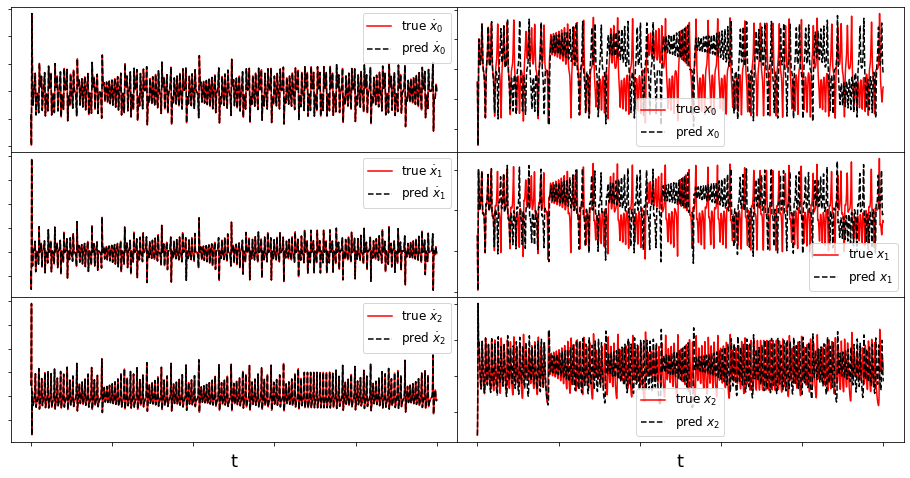

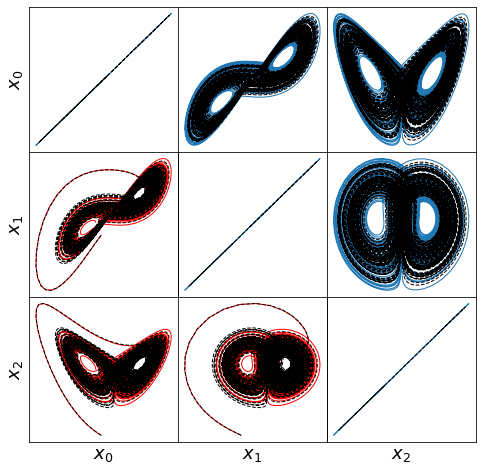

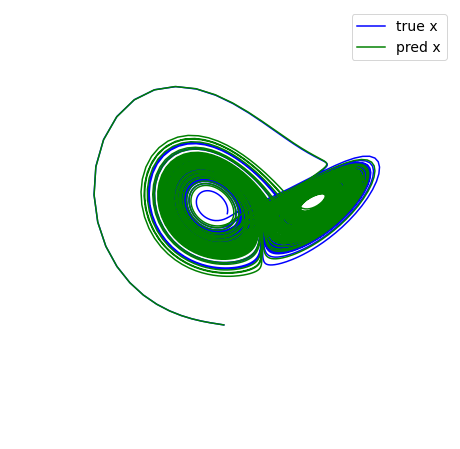

(10001,) (10001,)
optimal m:  [-1.08242681 -0.11549431 37.86821738]
As eigvals:  [-9.97361822 -2.65979867 -0.98318482]
Estimate of trapping region size, Rm =  106.91675154979
Normalized trapping region size, Reff =  4.482035267635106
Frobenius error =  0.7500142095378675
Frobenius coefficient error =  0.01046859886356529
Time-averaged derivative error =  1.2106790385097002e-05


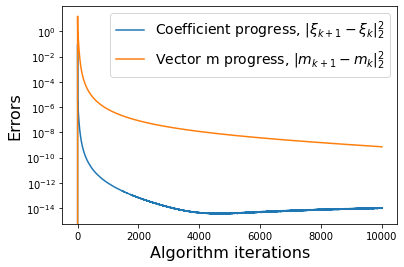

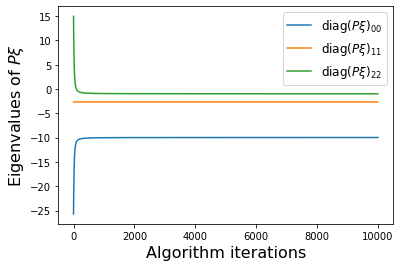

In [ ]:
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'lorenz')
make_3d_plots(x_test, x_test_pred, 'lorenz')
make_progress_plots(r, sindy_opt)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_stability(r, Xi, sindy_opt, mean_val)
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)

# compute relative Frobenius error in the model coefficients
sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1
coef_pred = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :],
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))